In [1]:
!pip install pandas_datareader

In [2]:
!pip install fix_yahoo_finance

In [3]:
import pandas as pd
import pandas_datareader.data as web
import fix_yahoo_finance
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.api import abline_plot
import patsy
import seaborn as sns
sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1, rc=None)
import warnings
warnings.simplefilter('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [0]:
# Grab 10 years of Apple and NASDAQ data.  
# Note that the old Yahoo Finance API was deprecated.  (Thanks, Verizon!  That Marissa pay-out was steep.)
# Ran Aroussi has developed a fix that saves accessibility to Yahoo Finance. Thanks, Ran! Great stuff. 

start, end = "2006-01-01", "2016-12-31"
aapl_all = web.get_data_yahoo("aapl", start=start, end=end)
nasdaq_all = web.get_data_yahoo("^ixic", start=start, end=end)
aapl = aapl_all['Adj Close']
nasdaq = nasdaq_all['Adj Close']

Text(0.5,1,'10 Years of AAPL ($/Share)')

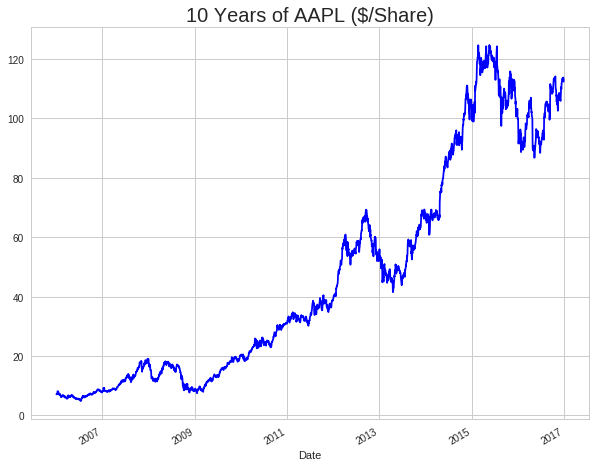

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 8))
aapl.plot(color='blue')
plt.title('10 Years of AAPL ($/Share)', fontsize=20)

Text(0.5,1,'10 Years of NASDAQ Index')

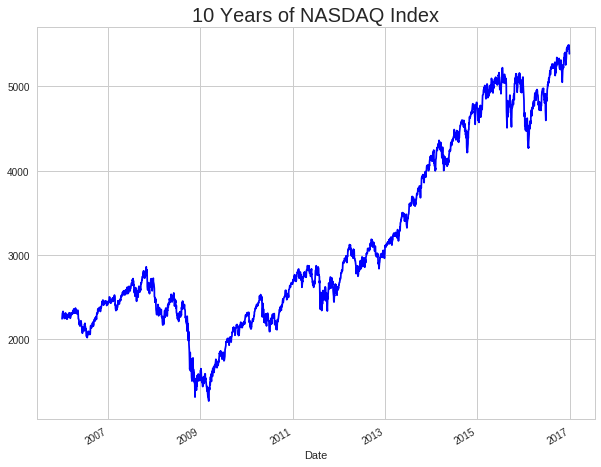

In [7]:
plt.figure(figsize = (10, 8))
nasdaq.plot(color='blue')
plt.title('10 Years of NASDAQ Index', fontsize=20)

In [0]:
# Calculate daily returns.
import numpy as np
aapl_returns = np.log(aapl / aapl.shift(1))
nasdaq_returns = np.log(nasdaq / nasdaq.shift(1))
aapl_returns = aapl_returns.dropna()
nasdaq_returns = nasdaq_returns.dropna()

(0, 50)

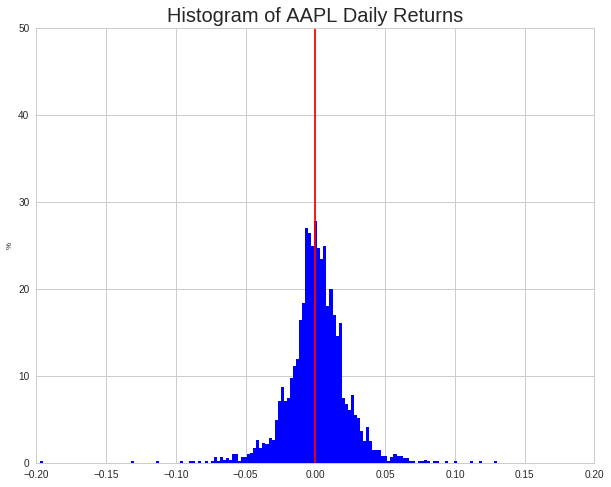

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.hist(aapl_returns, bins=150, normed=True, color='blue')
plt.title('Histogram of AAPL Daily Returns', fontsize=20)
plt.ylabel('%', fontsize=8)
plt.axvline(0, color='red')
plt.xlim(-0.2, 0.2)
plt.ylim(0, 50)

(0, 50)

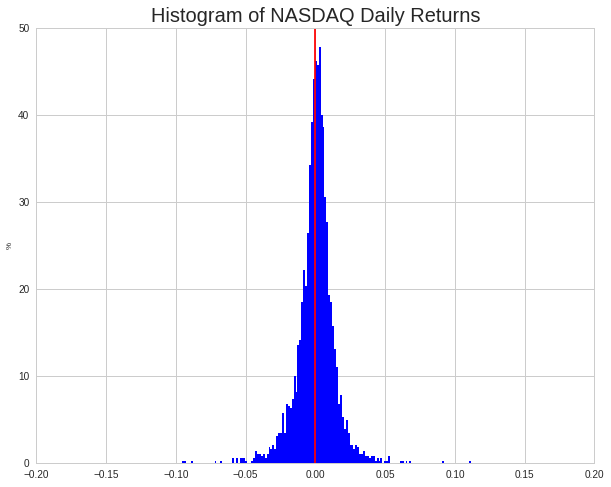

In [10]:
plt.figure(figsize=(10, 8))
plt.hist(nasdaq_returns, bins=150, normed=True, color='blue')
plt.title('Histogram of NASDAQ Daily Returns', fontsize=20)
plt.ylabel('%', fontsize=8)
plt.axvline(0, color='red')
plt.xlim(-0.2, 0.2)
plt.ylim(0, 50)

In [0]:

aapl_returns = pd.DataFrame(aapl_returns)
nasdaq_returns = pd.DataFrame(nasdaq_returns)

In [12]:
print(aapl_returns.describe())
print("")
print(nasdaq_returns.describe())

         Adj Close
count  2768.000000
mean      0.000995
std       0.021157
min      -0.197470
25%      -0.009041
50%       0.000922
75%       0.011983
max       0.130195

         Adj Close
count  2768.000000
mean      0.000316
std       0.013625
min      -0.095877
25%      -0.005389
50%       0.000925
75%       0.006788
max       0.111594


(array([-0.2]), array([0.2]))

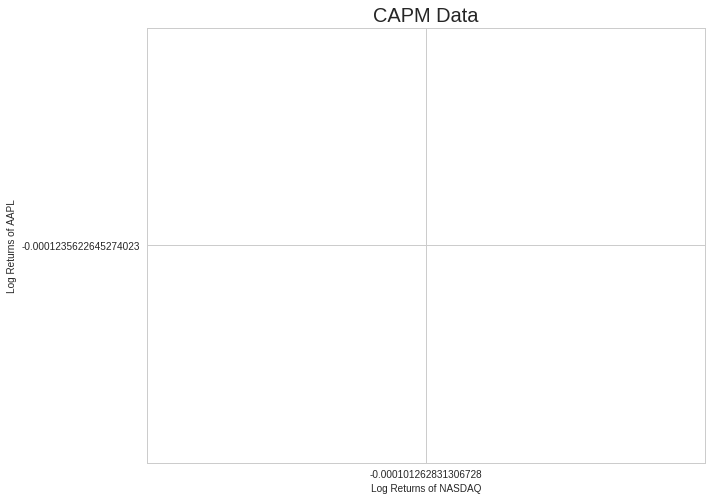

In [13]:
plt.figure(figsize = (10, 8))
plt.scatter(aapl_returns, nasdaq_returns, color='blue')
plt.title('CAPM Data', fontsize = 20)
plt.xlabel('Log Returns of NASDAQ', fontsize = 10)
plt.ylabel('Log Returns of AAPL', fontsize = 10)
plt.xlim([-0.2, 0.2])
plt.ylim([-0.2, 0.2])

In [14]:
from __future__ import print_function
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.cross_validation import  train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import math

# to not display the warnings of tensorflow
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [0]:
# parameters to be set ("optimum" hyperparameters obtained from grid search):
look_back = 3
epochs = 10
batch_size = 32

In [0]:
np.random.seed(7)

In [0]:
data = pd.merge(nasdaq_returns, aapl_returns, left_index=True, right_index=True)
data.rename(columns={'Adj Close_x':'nasdaq', 'Adj Close_y':'aapl'}, inplace=True)
datatrain, datatest = train_test_split(data, test_size = 0.2, random_state=10191987)

In [18]:
data.head()

,nasdaq,aapl
Date,,
2006-01-04,0.008750,0.002939
2006-01-05,0.005907,-0.007901
2006-01-06,0.012548,0.025486
2006-01-09,0.005653,-0.003282
2006-01-10,0.000703,0.061328


In [0]:
apple_stock_prices = data.aapl.values.astype('float32')

In [0]:
apple_stock_prices = apple_stock_prices.reshape(len(apple_stock_prices), 1)

In [0]:
scaler = MinMaxScaler(feature_range=(0, 1))
apple_stock_prices = scaler.fit_transform(apple_stock_prices)

In [22]:
train_size = int(len(apple_stock_prices) * 0.67)
test_size = len(apple_stock_prices) - train_size
train, test = apple_stock_prices[0:train_size,:], apple_stock_prices[train_size:len(apple_stock_prices),:]

print('Split data into training set and test set... Number of training samples/ test samples:', len(train), len(test))

Split data into training set and test set... Number of training samples/ test samples: 1854 914


In [0]:
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

# convert Apple's stock price data into time series dataset
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [0]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [25]:
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=epochs, batch_size=batch_size)

Epoch 1/10
1850/1850 [==============================] - 1s 314us/step - loss: 0.2116
Epoch 2/10
1850/1850 [==============================] - 0s 82us/step - loss: 0.0785
Epoch 3/10
1850/1850 [==============================] - 0s 82us/step - loss: 0.0193
Epoch 4/10
1850/1850 [==============================] - 0s 82us/step - loss: 0.0062
Epoch 5/10
1850/1850 [==============================] - 0s 84us/step - loss: 0.0055
Epoch 6/10
1850/1850 [==============================] - 0s 82us/step - loss: 0.0055
Epoch 7/10
1850/1850 [==============================] - 0s 84us/step - loss: 0.0055
Epoch 8/10
1850/1850 [==============================] - 0s 83us/step - loss: 0.0055
Epoch 9/10
1850/1850 [==============================] - 0s 83us/step - loss: 0.0055
Epoch 10/10
1850/1850 [==============================] - 0s 83us/step - loss: 0.0055


In [0]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [0]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [28]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.02 RMSE
Test Score: 0.02 RMSE


In [33]:
print('The average out-sample AAPL return is %f' % testY.mean())
print('The average predicted AAPL return is %f' % testPredict.mean())

The average out-sample AAPL return is 0.000922
The average predicted AAPL return is 0.000712


In [0]:
# shift predictions of training data for plotting
trainPredictPlot = np.empty_like(apple_stock_prices)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift predictions of test data for plotting
testPredictPlot = np.empty_like(apple_stock_prices)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(apple_stock_prices)-1, :] = testPredict

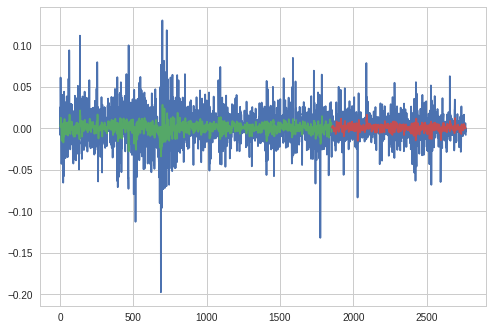

In [30]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(apple_stock_prices))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()